In [1]:
%matplotlib inline

# Select flaring gamma-ray sources


Mechanisms that produce an sudden increase in gamma-ray emission in astrophysical sources are not well known. The Fermi-LAT experiment monitors some of those high-enery emitting sources and publishes the measured flux each day. The lightcurves can be seen here: https://fermi.gsfc.nasa.gov/ssc/data/access/lat/msl_lc/.

It is interesting for multiwavelength astronomy to be able to automatically determine if an object is in flaring state, in order to make follow-up observations in other energy bands for example. However, since the internal mechanisms that produce an increase of gamma rays are not known, it is difficult to characterize the variability of each source and define what is really a flare.

What we try to do here is to make a very simple simulation of a lightcurve and of its variability in time, train the classifier on it and select or reject the lightcurve as 'flaring'.

# Simulation of lightcurves

A very simple simulation was chosen: random uniform noise is injected in a time period of two months (corresponding to short time analyses that could be interesting to do) and a Gaussian flare is injected with defined width, mean and amplitude. The ampltiude can be defined as once, twice or more the spread of the uniform noise. 


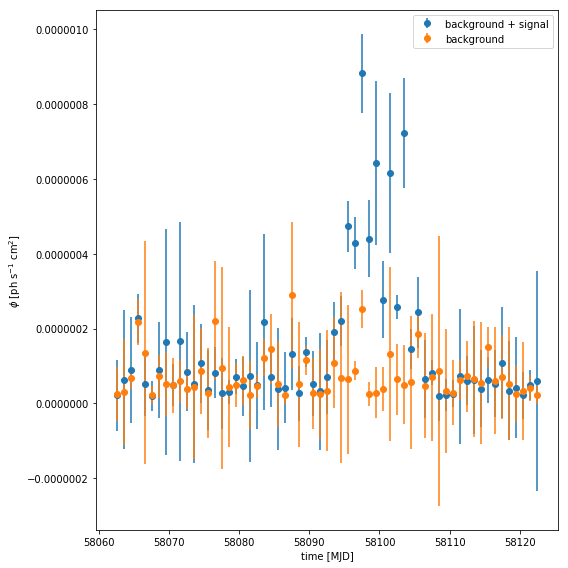

In [2]:
from simulateLC import makeLC

makeLC(mu=58100, sigma=4, amp=12, tmin=58062.5, tmax=58123.5, scaled=True)

More sophsiticated simulation could be done. An interesting example is described here: http://adsabs.harvard.edu/full/1995A%26A...300..707T
However, for now, we will use this simplified case.

# Real data and denoising with Bayesian blocks method

The image below shows the flux of a blazar (3C 279) as a function of time. The black points are the data. The pink line is the output of a denoising method called Bayesian Blocks (https://arxiv.org/abs/astro-ph/9711233) and the triangle represents a method used to determine if the lightcurve is variable enough to be interesting. 

The data is downloaded from the Fermi-LAT monitored list website and the liughtcurve is constructed using Fermi tools package. We will use directly the pre-processed files in order to test the classifiers on them. 

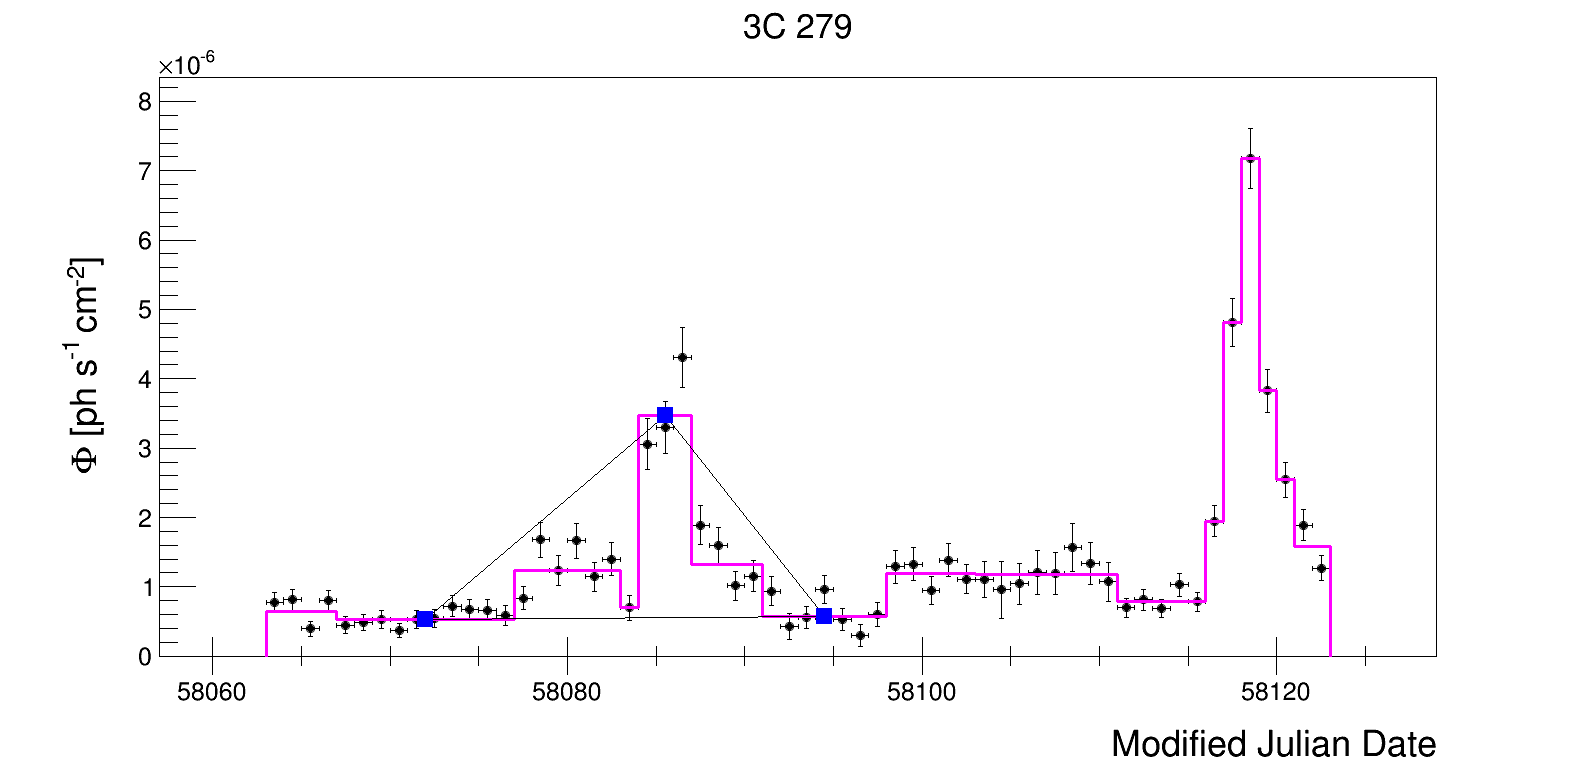

In [3]:
from IPython.display import Image
Image(filename='/home/stephanie/Documents/Physique/Doctorat/Cours/advanced-computing-2018/project/58063_to_58123_selectedSources/lc_3C_279_194.047_-5.789_1day.png')

### Creating the data

The real data files consist in bins of 1 day containing:
- time
- count
- error on the count
- exposure of the telescope

The count and error on the count are then normalized by the exposure. Thus the data files are reduced to 3 columns: time, flux and flux error. 

The simulation files are produced in the same way. The count is taken from the random noise set during 2 months and the additional gaussian flare, with mean $\mu$ and width $\sigma$ and a defined amplitude $A$. The error on the count is taken randomly within a defined range and the exposure is sampled randomly within realistic values.
In the simulation file, a '1' is added in the last column is a gaussian was added to the noise. Otherwise, a 0 is written in the last column.

In [1]:
from createDataFiles import createFileRealData, createSimulationFile

createFileRealData(filesPath = 'lcFinalFMonitored_from_58063_to_58123_EMin_100.0MeV/', tmin=58063.5, \
                        tmax=58123.5, filename='realData.csv')

createSimulationFile(mu=58100, sigma=[3], amp=[16], tmin=58063.5, tmax=58123.5, nloopsSig=8535, nloopsBkg=10864, \
                            filename='fileSimulation.csv')

File  realData.csv  found, removing it...
Creating data file realData.csv
File  fileSimulation.csv  found, removing it...
Creating data file fileSimulation.csv


### Loading the data

In [2]:
import pandas as pd
import numpy as np

simulation = pd.read_csv("fileSimulation.csv", header=None)
simulation = simulation.sample(frac=1).reset_index(drop=True)
simulation.head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,58063.5,58064.5,58065.5,58066.5,58067.5,58068.5,58069.5,58070.5,58071.5,58072.5,...,1.406652e-07,7.983395e-08,4.054120e-08,7.254277e-08,1.744486e-07,1.521973e-07,3.683835e-07,1.412312e-07,1.126575e-07,0.0
1,58063.5,58064.5,58065.5,58066.5,58067.5,58068.5,58069.5,58070.5,58071.5,58072.5,...,1.486547e-07,4.387323e-08,1.178000e-07,1.116538e-07,4.760406e-08,5.560167e-08,1.151314e-07,1.367284e-07,1.001563e-07,1.0
2,58063.5,58064.5,58065.5,58066.5,58067.5,58068.5,58069.5,58070.5,58071.5,58072.5,...,1.143967e-07,1.025984e-07,6.644434e-08,1.338627e-07,5.486393e-08,5.473680e-08,1.422205e-07,9.356708e-08,1.177230e-07,1.0
3,58063.5,58064.5,58065.5,58066.5,58067.5,58068.5,58069.5,58070.5,58071.5,58072.5,...,1.410403e-07,9.680853e-08,4.866285e-08,1.242814e-07,2.567735e-07,7.069181e-08,3.797738e-08,5.814969e-08,5.552664e-08,0.0
4,58063.5,58064.5,58065.5,58066.5,58067.5,58068.5,58069.5,58070.5,58071.5,58072.5,...,9.590510e-08,2.054699e-07,7.648519e-08,6.156862e-08,1.035977e-07,1.247681e-07,7.147138e-08,2.847820e-07,1.280581e-07,1.0


In [5]:
#select only last columns as target and convert it to integer (it is binary: 1 = flare, 0 = noise)
target = simulation[180]
target = np.asarray(target).astype(int)
print(len(target))

19399


In [6]:
#select all the rest in order to train and test classifiers
simu_x = simulation.loc[:, simulation.columns != 180]
#simu_x.head()

Note: The shape of the data was a bit of a problem. Since for each entry, I got an array of dates, of fluxes and of fluxes error, I had to flatten it and I get one feature per day, per flux for this day and per flux error for this day. Since we are building 2 months lightcurves and the bins are of 1 day, we have 180 features but in reality only 3 different type of features, i.e. time, flux and flux error. 
There should be a better way to deal with that in order to make the features more meanigful. Unfortunately I don't have the time to investigate this more. 

# Training and testing of classifiers

## Random forest

In [7]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [8]:
X_train, X_test, y_train, y_test = train_test_split(simu_x, target, train_size=0.7)

/home/stephanie/anaconda3/envs/adv-comp-18/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
from classifiers import randomForest

bestClf_rf, bestParam_rf, prediction_rf = randomForest(X_train, y_train, X_test)

/home/stephanie/anaconda3/envs/adv-comp-18/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


====================  Random forest results ===========================
Best params: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}
Accuracy: 0.5628865979381443
AUC ROC score 0.500196463654224


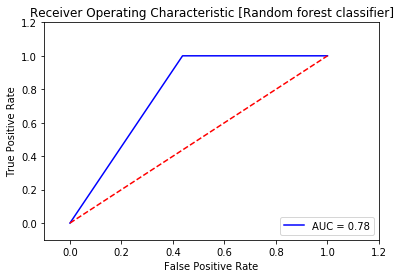

In [10]:
print('====================  Random forest results ===========================')
print('Best params:', bestParam_rf) 
print('Accuracy:', bestClf_rf.score(X_test, y_test))   
print('AUC ROC score', roc_auc_score(y_test, prediction_rf))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction_rf, y_test)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic [Random forest classifier]')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Gradient boosting

In [11]:
from classifiers import gradientBoosting

bestClf_gb, bestParam_gb, prediction_gb = gradientBoosting(X_train, y_train, X_test)

====================  Random forest results ===========================
Best params: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'auto'}
Accuracy: 0.5630584192439863
AUC ROC score 0.500392927308448


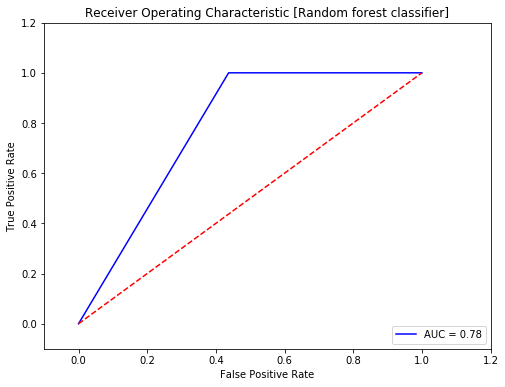

In [12]:
print('====================  Random forest results ===========================')
print('Best params:', bestParam_gb) 
print('Accuracy:', bestClf_gb.score(X_test, y_test))   
print('AUC ROC score', roc_auc_score(y_test, prediction_gb))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction_gb, y_test)
roc_auc = auc(false_positive_rate, true_positive_rate)

fig = plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic [Random forest classifier]')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural Network

In [13]:
#quick conversion of the target in [[1,0], [0,1], ...]
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

Y_ = one_hot(2, target)
print(Y_)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [14]:
X_train, X_val, y_train, y_val = train_test_split(simu_x, Y_, train_size=0.7)

/home/stephanie/anaconda3/envs/adv-comp-18/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
from classifiers import NN

model = NN()

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                3620      
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
_________________________________________________________________
activation_3 (Activation)    (None, 4)                 0         
__________

### Compile the model

In [17]:
from keras import optimizers

adm = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
            optimizer=adm,
            metrics=['accuracy'])

In [18]:
batch_size = 128

history = model.fit(X_train, y_train, 
                  epochs=20, verbose=1, 
                  batch_size=batch_size, 
                  validation_data=(X_val, y_val))

Train on 13579 samples, validate on 5820 samples
Epoch 1/20
13579/13579 [==============================] - 1s 48us/step - loss: 7.1112 - acc: 0.5588 - val_loss: 7.0454 - val_acc: 0.5629
Epoch 2/20
13579/13579 [==============================] - 0s 23us/step - loss: 7.1112 - acc: 0.5588 - val_loss: 7.0454 - val_acc: 0.5629
Epoch 3/20
13579/13579 [==============================] - 0s 25us/step - loss: 7.1112 - acc: 0.5588 - val_loss: 7.0454 - val_acc: 0.5629
Epoch 4/20
13579/13579 [==============================] - 0s 26us/step - loss: 7.1112 - acc: 0.5588 - val_loss: 7.0454 - val_acc: 0.5629
Epoch 5/20
13579/13579 [==============================] - 0s 28us/step - loss: 7.1112 - acc: 0.5588 - val_loss: 7.0454 - val_acc: 0.5629
Epoch 6/20
13579/13579 [==============================] - 0s 24us/step - loss: 7.1112 - acc: 0.5588 - val_loss: 7.0454 - val_acc: 0.5629
Epoch 7/20
13579/13579 [==============================] - 0s 22us/step - loss: 7.1112 - acc: 0.5588 - val_loss: 7.0454 - val_acc:

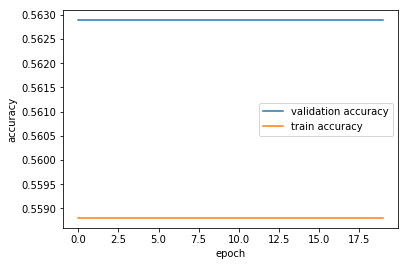

In [19]:
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.plot(history.history['acc'], label='train accuracy')
#plt.ylim([0, ])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='best')

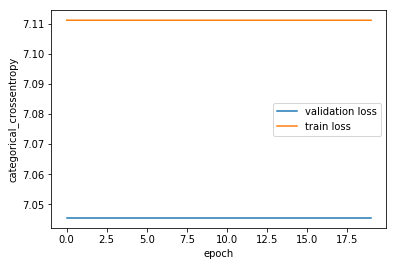

In [20]:
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['loss'], label='train loss')
#plt.ylim([0, ])
plt.xlabel('epoch')
plt.ylabel('categorical_crossentropy')
plt.legend()

## Prediction on real data

We don't know what are the real flares or not in our sample of real lightcurves. However, as presented above, techniques are used in order to denoise the lightcurve and to quantify its variability. The idea would be to compare the lightcurves tagged by the classifiers as comporting a flare and the ones tagged by the currently used method.  

In [21]:
realData = pd.read_csv("realData.csv", header=None)

In [22]:
pred_rf = bestClf_rf.predict(realData)

selectedFlares = len(pred_rf[pred_rf==1])
rejectedFlares = len(pred_rf[pred_rf==0])

print('Random forest:')
print('Number of selected lightcurves:', selectedFlares)
print('Number of rejected lightcurves:', rejectedFlares)

with open("sources.txt", "r") as ins:
    array = []
    for line in ins:
        array.append(line)
        
array = np.asarray(array)

selectedSources = array[pred_rf==1]
rejectedSources = array[pred_rf==0]

print('Selected sources', selectedSources)
print('Rejected sources', rejectedSources)

Random forest:
Number of selected lightcurves: 39
Number of rejected lightcurves: 116
Selected sources ['PKS_0336-01_54.879_-1.777\n' '3C_279_194.047_-5.789\n'
 'Cygnus_X-3_308.107_40.958\n' 'LSI_p61_303_40.131_61.229\n'
 '0208-512_32.693_-51.017\n' 'CTA_102_338.152_11.731\n'
 'PMN_J1038-5311_159.669_-53.195\n' 'PMN_J1123-6417_170.828_-64.297\n'
 'PMN_J0852-5755_133.161_-57.925\n' 'PMN_J1626-2426_246.75_-24.445\n'
 'PKS_B_1622-297_246.525_-29.857\n' 'TXS_1923p123_291.42_12.461\n'
 'PKS_0903-57_136.222_-57.585\n' 'J1057-6027_164.308_-60.458\n'
 '3EG_J0903-3531_136.202_-35.256\n' 'PKS_1424-41_216.985_-42.105\n'
 '4C_p50d11_59.874_50.964\n' 'PKS_2247-131_342.498_-12.855\n'
 'BL_Lac_330.68_42.278\n' 'PKS_1502p106_226.104_10.494\n'
 '4C_14d23_111.32_14.42\n' '1510-089_228.17_-8.83\n'
 'OT_081_267.887_9.65\n' 'PKS_0727-11_112.58_-11.687\n'
 'PKS_0805-07_122.065_-7.853\n' 'PKS_0920-39_140.693_-39.993\n'
 'Ton_599_179.883_29.246\n' 'PKS_2149-306_327.981_-30.465\n'
 'OK_p630_140.401_62.264\n' '

In [23]:
pred_gb = bestClf_gb.predict(realData)

selectedFlares = len(pred_gb[pred_gb==1])
rejectedFlares = len(pred_gb[pred_gb==0])

print('Gradient boosting:')
print('Number of selected lightcurves:', selectedFlares)
print('Number of rejected lightcurves:', rejectedFlares)

with open("sources.txt", "r") as ins:
    array = []
    for line in ins:
        array.append(line)
        
array = np.asarray(array)

selectedSources = array[pred_gb==1]
rejectedSources = array[pred_gb==0]

print('Selected sources', selectedSources)
print('Rejected sources', rejectedSources)

Gradient boosting:
Number of selected lightcurves: 47
Number of rejected lightcurves: 108
Selected sources ['PKS_0336-01_54.879_-1.777\n' '3C_279_194.047_-5.789\n'
 'Cygnus_X-3_308.107_40.958\n' 'LSI_p61_303_40.131_61.229\n'
 '0208-512_32.693_-51.017\n' 'CTA_102_338.152_11.731\n'
 'PMN_J1038-5311_159.669_-53.195\n' 'J1512-3221_228.04_-32.36\n'
 'PMN_J1123-6417_170.828_-64.297\n' 'PMN_J0852-5755_133.161_-57.925\n'
 'PMN_J2250-2806_342.685_-28.11\n' 'PMN_J1626-2426_246.75_-24.445\n'
 'PKS_B_1622-297_246.525_-29.857\n' 'TXS_1923p123_291.42_12.461\n'
 'PKS_0903-57_136.222_-57.585\n' 'J1057-6027_164.308_-60.458\n'
 '3EG_J0903-3531_136.202_-35.256\n' 'Fermi_J1717-5156_259.394_-51.925\n'
 'PKS_2255-282_344.525_-27.973\n' 'PKS_B1908-201_287.79_-20.115\n'
 'PKS_1424-41_216.985_-42.105\n' '4C_p50d11_59.874_50.964\n'
 'PKS_1622-253_246.445_-25.461\n' 'PKS_2247-131_342.498_-12.855\n'
 'BL_Lac_330.68_42.278\n' 'PKS_1502p106_226.104_10.494\n'
 '4C_14d23_111.32_14.42\n' 'NRAO_676_330.431_50.816\n'
 '

In [26]:
pred_NN = model.predict(realData)
pred_NN[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Conclusion

We produced a simulation of gamma-ray lightcurves of two months duration and trained different classifiers on it. We then tested them on real data. The last step would be to compare the sources that were selected or rejected with the classic method that is used for this task.

We see that this doesn't work, especially for the neural network. There could be different reasons, like for example that we didn't simulate enough different types of lightcurves or just not enough lightcurves at all, the simulation is not good, we would need to pre-process more the files in order to get more pertinent variables or that the classifiers were not optimized enough. Due to a lack of time, I can't unfortunately check those hypotheses. 
